In [6]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
protoFile = "hands/pose_deploy.prototxt"
weightsFile = "hands/pose_iter_102000.caffemodel"
nPoints = 22
POSE_PAIRS = [ [7,8],[11,12],[15,16],[19,20] ]
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [7]:
frame = cv2.imread("left_palm.jpg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
aspect_ratio = frameWidth/frameHeight
threshold = 0.1

t = time.time()
# input image dimensions for the network
inHeight = 368
# inWidth = 368
inWidth = int(((aspect_ratio*inHeight)*8)//8)
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))
print(output.shape)

time taken by network : 1.020
(1, 22, 46, 26)


[[ 822  832]
 [1254  657]
 [1601 1007]
 [1946 1534]]


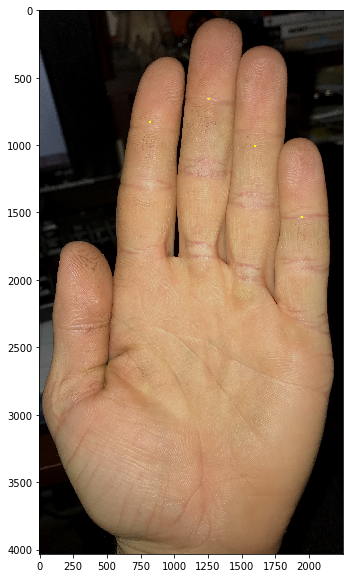

In [8]:
# Empty list to store the detected keypoints
points = []


for i in (7,11,15,18) :
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frameWidth, frameHeight))    
    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    cv2.circle(frameCopy, (int(point[0]), int(point[1])), 3, (0, 255, 255), thickness=10, lineType=cv2.FILLED)
    points.append((int(point[0]), int(point[1])))
points = np.array(points)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
print(points)

In [9]:
points

array([[ 822,  832],
       [1254,  657],
       [1601, 1007],
       [1946, 1534]])

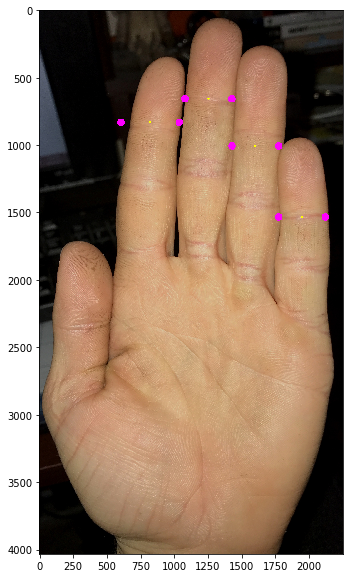

In [10]:
fg = frameCopy
a = np.zeros((4,2))
for i in range(3):
    x1 = int(points[i][0])
    x2 = int(points[i+1][0])
    x_l = x1 - ((x2-x1)/2)
    x_h = x1 + ((x2-x1)/2)
    cv2.circle(fg, (int(x_l), int(points[i][1])), 3, (255, 0, 255), thickness=50, lineType=cv2.FILLED)    
    cv2.circle(fg, (int(x_h), int(points[i][1])), 3, (255, 0, 255), thickness=50, lineType=cv2.FILLED)
    a[i][0]=x_l
    a[i][1]=x_h

x1 = int(points[2][0])
x2 = int(points[3][0])
x_l = x2 - ((x2-x1)/2)
x_h = x2 + ((x2-x1)/2)
cv2.circle(fg, (int(x_l), int(points[3][1])), 3, (255, 0, 255), thickness=50, lineType=cv2.FILLED)    
cv2.circle(fg, (int(x_h), int(points[3][1])), 3, (255, 0, 255), thickness=50, lineType=cv2.FILLED)
a[3][0]=x_l
a[3][1]=x_h
    
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(fg, cv2.COLOR_BGR2RGB))

In [11]:
print(a)

[[ 606.  1038. ]
 [1080.5 1427.5]
 [1428.5 1773.5]
 [1773.5 2118.5]]


[]

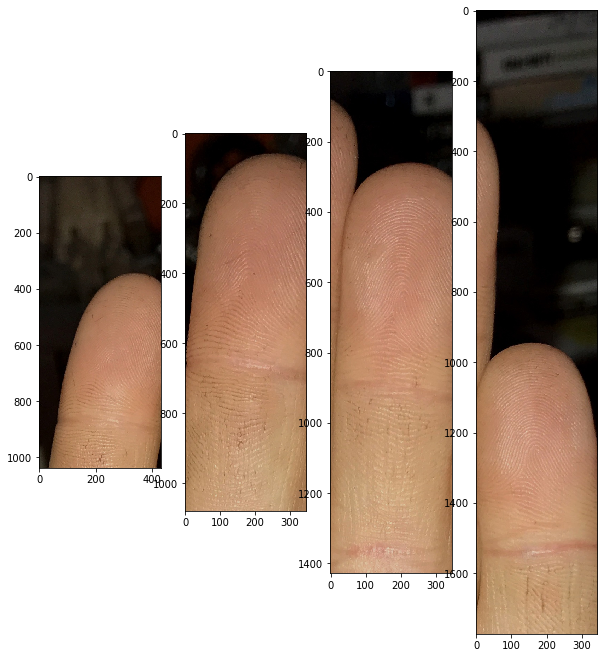

In [12]:
fingers = []

plt.figure(figsize=[10,40])

x_l = int(a[0][0])
x_h = int(a[0][1])
img = frame[:x_h,x_l:x_h]
plt.subplot(1,4,1)
#plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
fingers.append(img)
    
for i in range(1,4):
    x_l = int(a[i][0])
    x_h = int(a[i][1])
    img = frame[:x_l,x_l:x_h]
    plt.subplot(1,4,i+1)
    #plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fingers.append(img)
plt.plot()

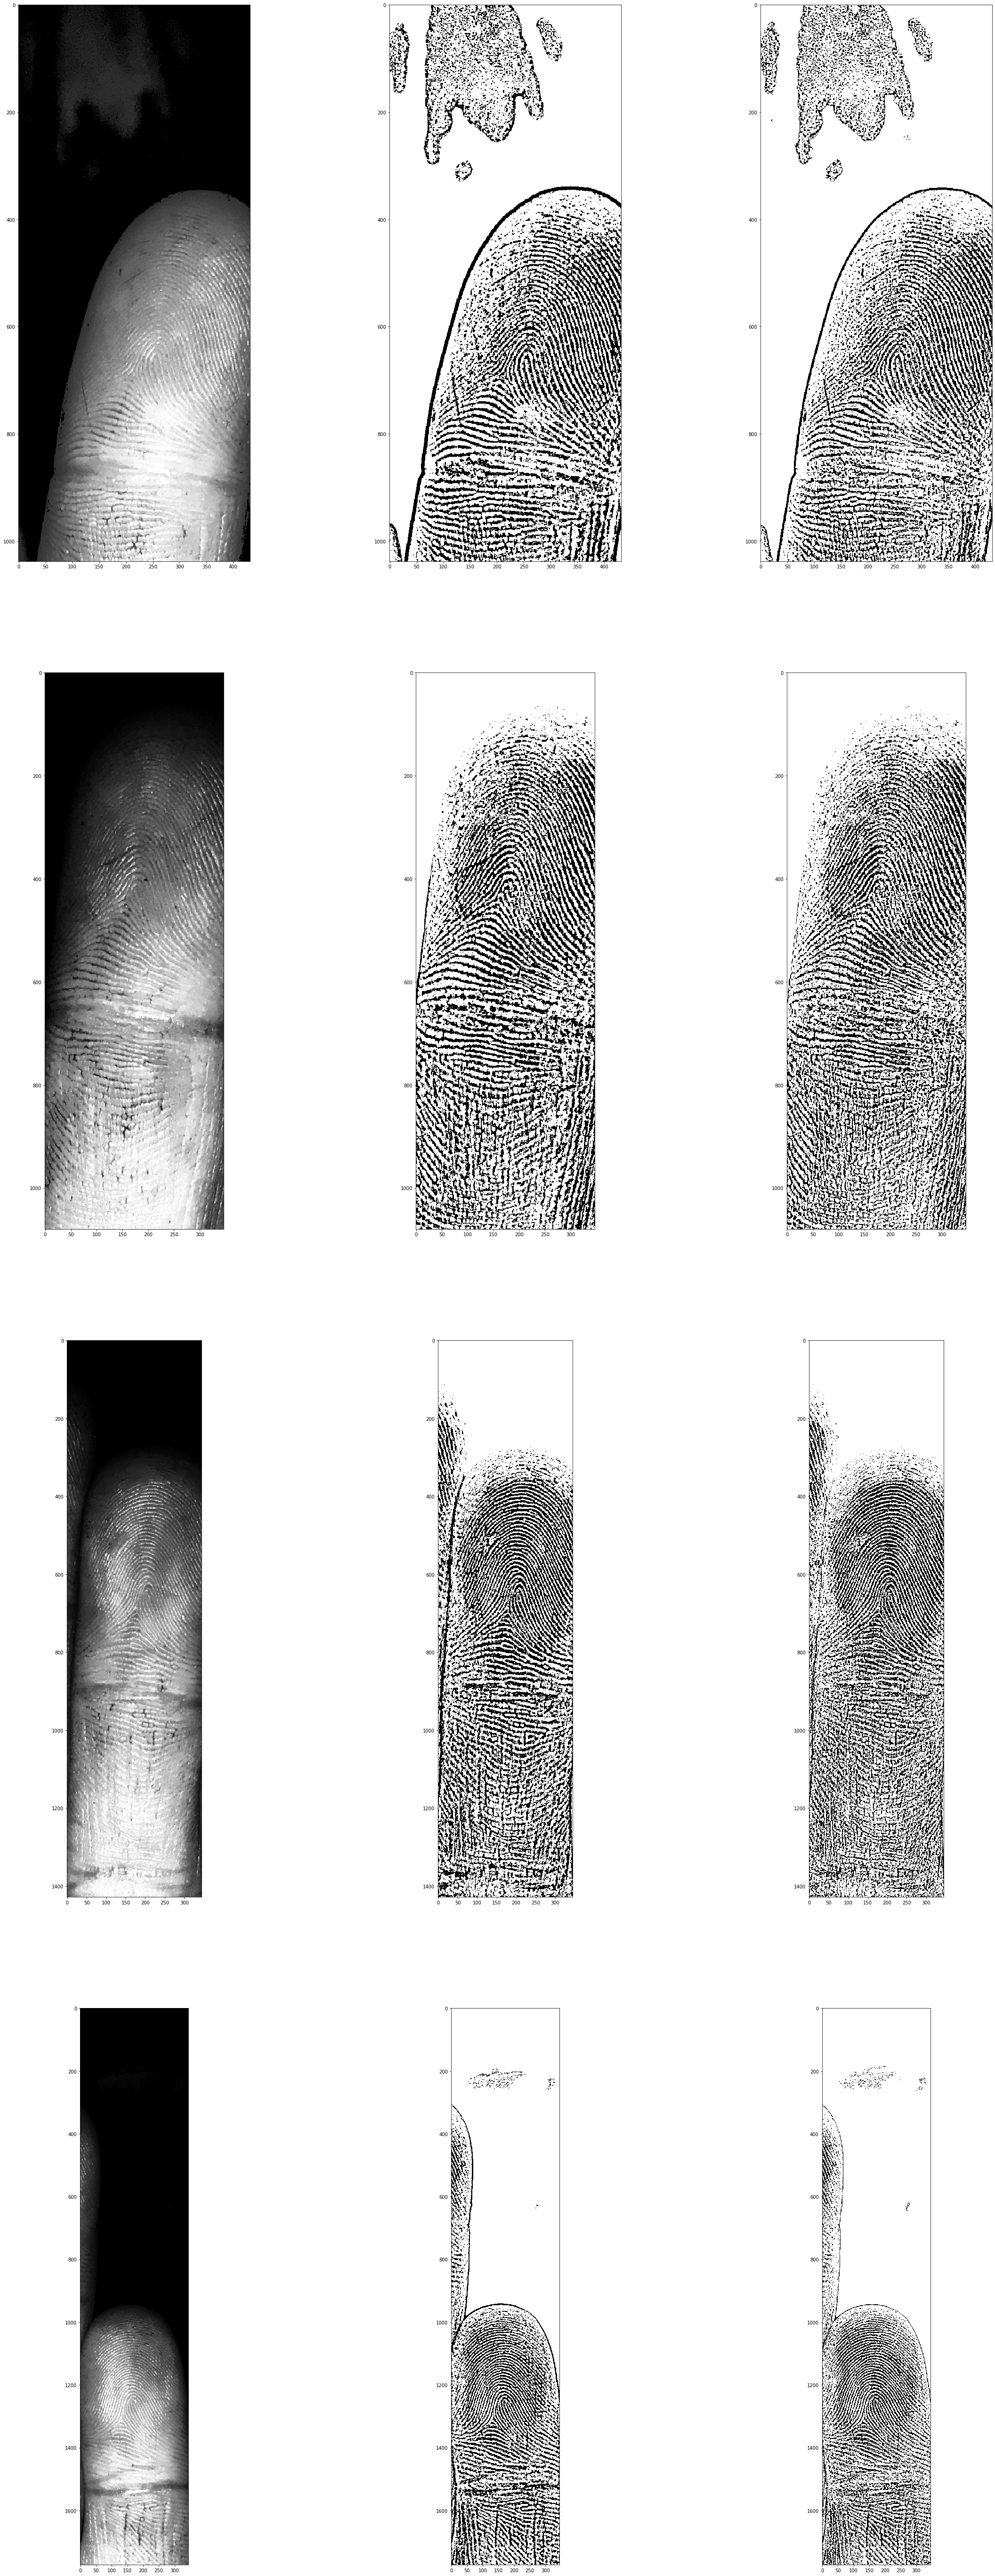

In [29]:
plt.figure(figsize=[40,100])
for i in range(4):
    hsv_blue = cv2.cvtColor(fingers[i],cv2.COLOR_BGR2HSV)
    lw_blue = np.array([0,55,45])
    up_blue = np.array([250,160,235])
    mask = cv2.inRange(hsv_blue,lw_blue,up_blue)
    nw_img = cv2.bitwise_and(fingers[i],fingers[i],mask=mask)
    nw = cv2.cvtColor(nw_img , cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(nw , cv2.COLOR_RGB2GRAY)
    xy = cv2.equalizeHist(gray)

    prev = xy
    normalizedImg = np.array(xy,dtype='float32')
    plt.subplot(4,3,(i*3)+1)
    plt.imshow(normalizedImg , cmap='gray')
    prev = cv2.adaptiveThreshold(xy,0.75,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,15,3)
    prev2 = cv2.adaptiveThreshold(xy,0.55,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,15,3)
    # plt.subplot(2,2,1)
    # plt.imshow(xy,cmap='gray')
    plt.subplot(4,3,i*3+2)
    plt.imshow(prev,cmap='gray')
    plt.subplot(4,3,i*3+3)
    plt.imshow(prev2,cmap='gray')
    plt.plot()